Objective: Create a model that predicts whether or not a loan will be default using the historical data.

Problem Statement:  
For companies like Lending Club correctly predicting whether or not a loan will be a default is very important.
In this project, using the historical data from 2007 to 2015, you have to build a deep learning model to predict
the chance of default for future loans. As you will see later this dataset is highly imbalanced and includes a
lot of features that make this problem more challenging.
Domain: Finance

Analysis to be done: Perform data preprocessing and build a deep learning prediction model. 


In [84]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


1.     Feature Transformation

●	Transform categorical values into numerical values (discrete)


In [85]:

# 2. Load your dataset
df = pd.read_csv("D:/ai/projects/deep_learning/dataset/loan_data.csv")   



# 4. Exploratory Data Analysis (EDA)
print("\nDataset Info:\n")
print(df.info())

print("\nMissing Values:\n")
print(df.isnull().sum())

print("\nStatistical Description:\n")
print(df.describe())


dups=df.duplicated().sum()
print("\nDuplicated Records:\n")
print(dups)





Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
None

Missing Values:

credit.policy        0
p

2.  Exploratory data analysis of different factors of the dataset.

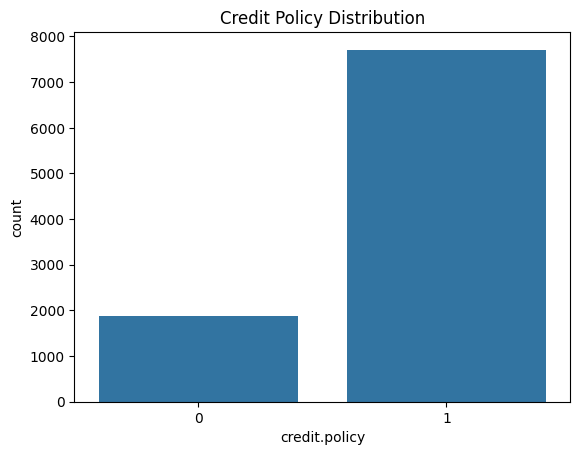

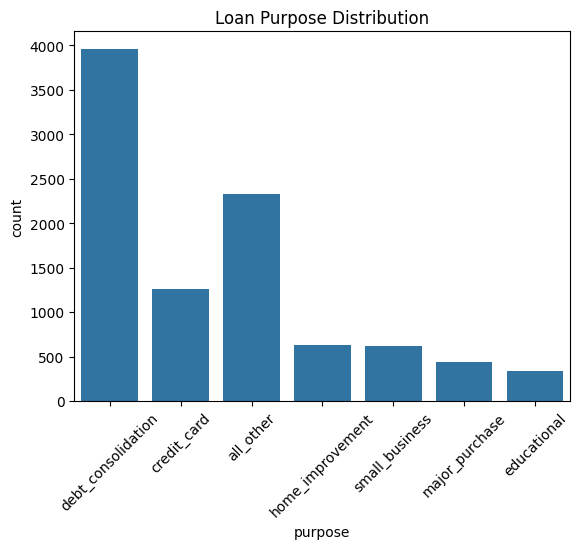

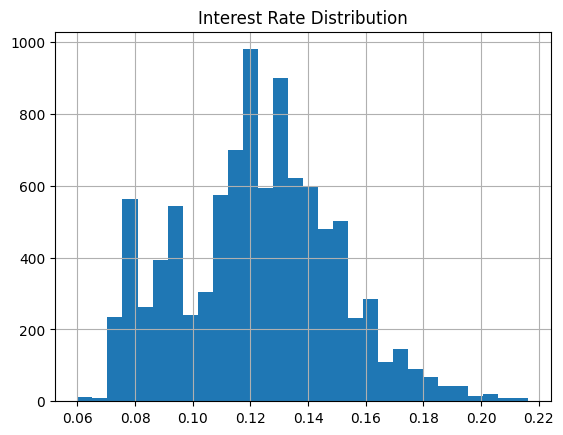

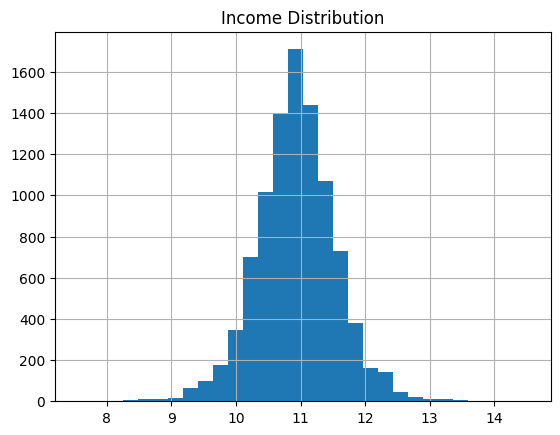

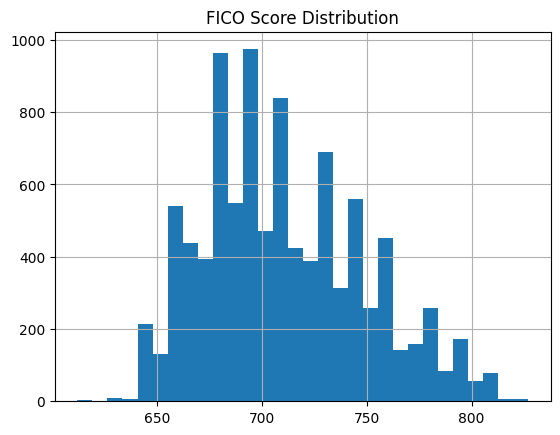

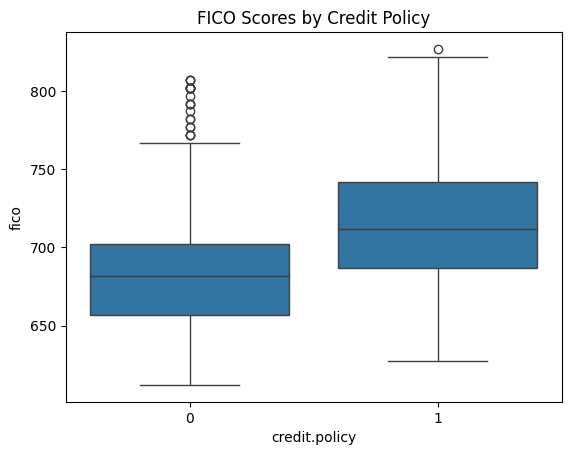

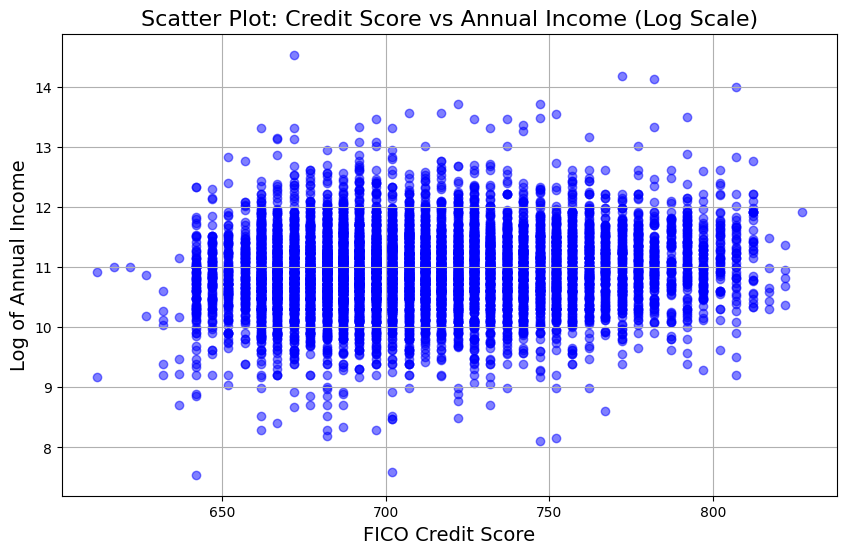

In [86]:
sns.countplot(x='credit.policy', data=df)
plt.title('Credit Policy Distribution')
plt.show()


sns.countplot(x='purpose', data=df)
plt.title('Loan Purpose Distribution')
plt.xticks(rotation=45)
plt.show()

df['int.rate'].hist(bins=30)
plt.title('Interest Rate Distribution')
plt.show()

df['log.annual.inc'].hist(bins=30)
plt.title('Income Distribution')
plt.show()

df['fico'].hist(bins=30)
plt.title('FICO Score Distribution')
plt.show()

sns.boxplot(x='credit.policy', y='fico', data=df)
plt.title('FICO Scores by Credit Policy')
plt.show()

# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df['fico'], df['log.annual.inc'], alpha=0.5, c='blue')

# Titles and labels
plt.title('Scatter Plot: Credit Score vs Annual Income (Log Scale)', fontsize=16)
plt.xlabel('FICO Credit Score', fontsize=14)
plt.ylabel('Log of Annual Income', fontsize=14)

# Grid and show
plt.grid(True)
plt.show()



3.     Additional Feature Engineering

●	You will check the correlation between features and will drop those features which have a strong correlation
●	This will help reduce the number of features and will leave you with the most relevant features


   credit.policy  int.rate  installment  log.annual.inc    dti  fico  \
0              1    0.1189       829.10       11.350407  19.48   737   
1              1    0.1071       228.22       11.082143  14.29   707   
2              1    0.1357       366.86       10.373491  11.63   682   
3              1    0.1008       162.34       11.350407   8.10   712   
4              1    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs  \
0        5639.958333      28854        52.1               0            0   
1        2760.000000      33623        76.7               0            0   
2        4710.000000       3511        25.6               1            0   
3        2699.958333      33667        73.2               1            0   
4        4066.000000       4740        39.5               0            1   

   pub.rec  not.fully.paid  purpose_credit_card  purpose_debt_consolidation  \
0        0               0     

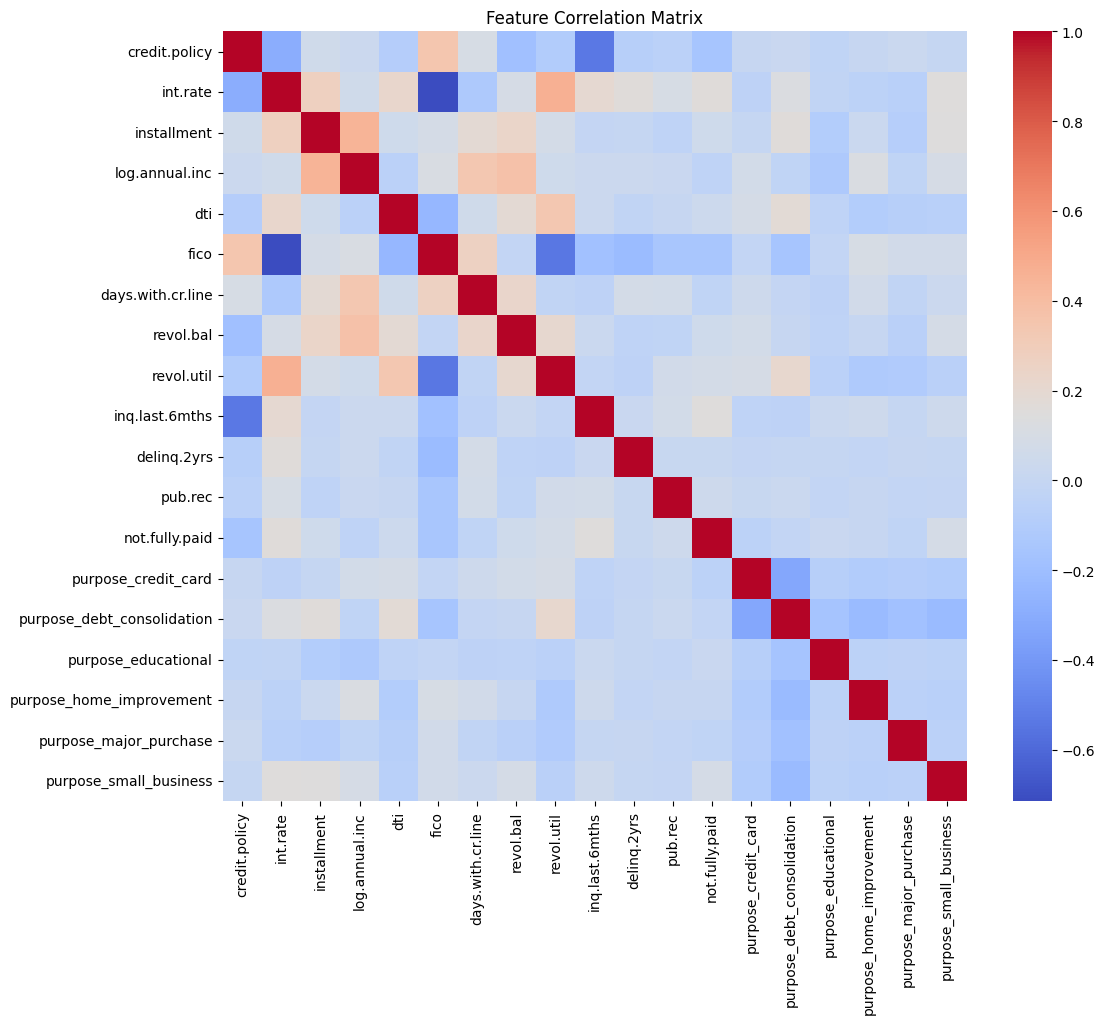

In [87]:
df=pd.get_dummies(df,columns=['purpose'],dtype=int,drop_first=True)
print(df.head())

# 5. Additional Feature Engineering - Correlation Analysis
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title('Feature Correlation Matrix')
plt.show()




In [88]:
#remove  installment (due to its correlation with int.rate), revol.util (due to its correlation with revol.bal)
df = df.drop(['revol.util', 'installment'], axis=1)

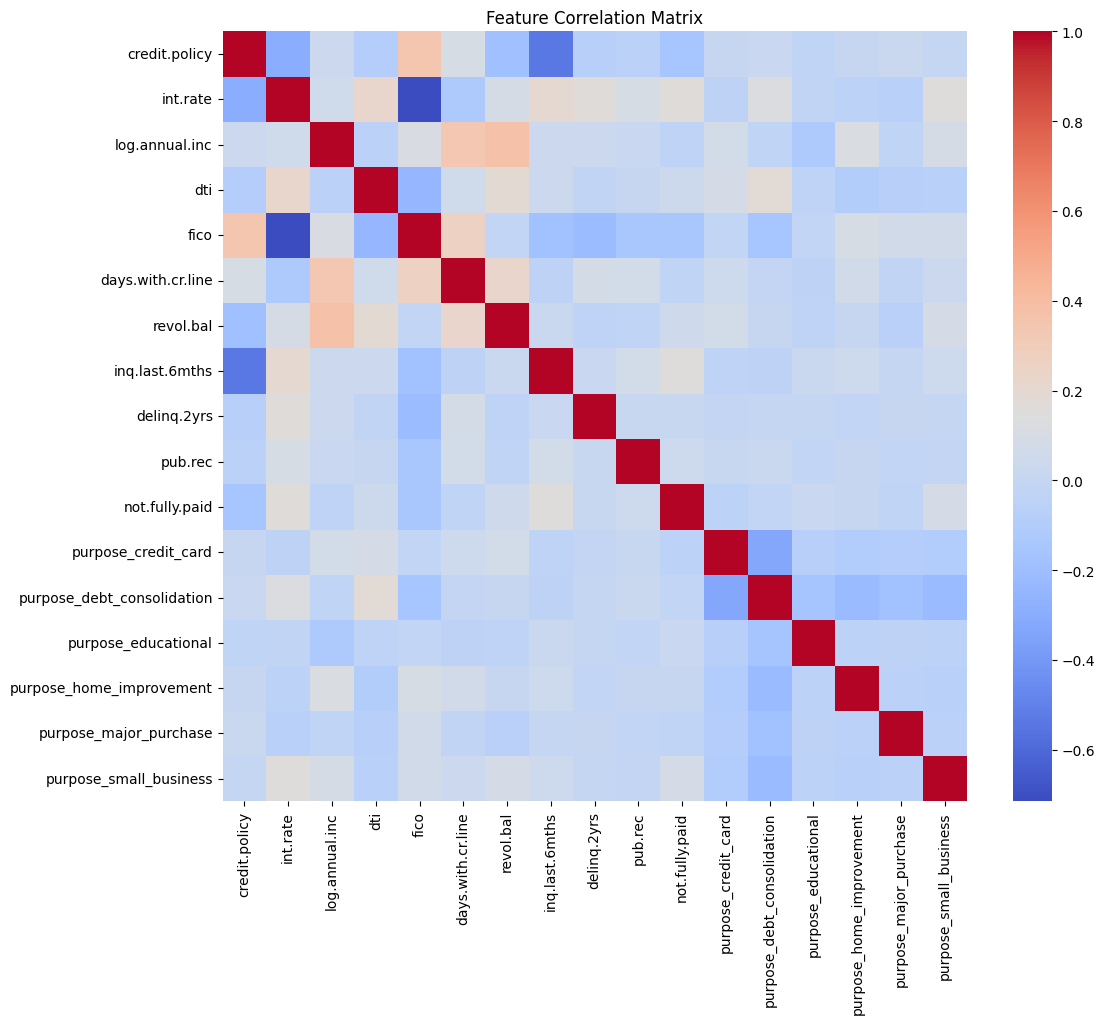

In [89]:

#  After removing highly corelated features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

4.     Modeling

●	After applying EDA and feature engineering, you are now ready to build the predictive models
●	In this part, you will create a deep learning model using Keras with Tensorflow backend

In [90]:
# 6. Prepare data
X = df.drop('credit.policy', axis=1)  # Target: 'credit.policy'
y = df['credit.policy']

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 8. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
# 9. SMOTE Oversampling
#sm = SMOTE(sampling_strategy=0.25,random_state=42)
#X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

#print("\nAfter SMOTE, class distribution:")
#print(pd.Series(y_train_smote).value_counts())

weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

In [92]:
# 10. Build Deep Learning Model
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],))) 
model.add(Dense(45, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# 11. Train Model
history = model.fit(X_train_scaled, y_train, 
                    epochs=25, batch_size=32, 
                    validation_data=(X_test_scaled, y_test),
                    class_weight=class_weights,
                   callbacks=[early_stop])

Epoch 1/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5701 - loss: 0.6673 - val_accuracy: 0.8257 - val_loss: 0.4482
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7811 - loss: 0.4735 - val_accuracy: 0.8528 - val_loss: 0.3668
Epoch 3/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8327 - loss: 0.3995 - val_accuracy: 0.8513 - val_loss: 0.3508
Epoch 4/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8362 - loss: 0.3844 - val_accuracy: 0.8732 - val_loss: 0.3179
Epoch 5/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8463 - loss: 0.3734 - val_accuracy: 0.8727 - val_loss: 0.3110
Epoch 6/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8527 - loss: 0.3573 - val_accuracy: 0.8659 - val_loss: 0.3191
Epoch 7/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8568 - loss: 0.3392 - val_accuracy: 0.8695 - val_loss: 0.3104
Epoch 8/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8647 - loss: 0.3311 - val_accuracy: 0.

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       374
           1       0.98      0.91      0.94      1542

    accuracy                           0.91      1916
   macro avg       0.84      0.91      0.87      1916
weighted avg       0.92      0.91      0.91      1916


ROC-AUC Score: 0.9731215797249214
Test Loss: 0.2207
Test Accuracy: 0.9102


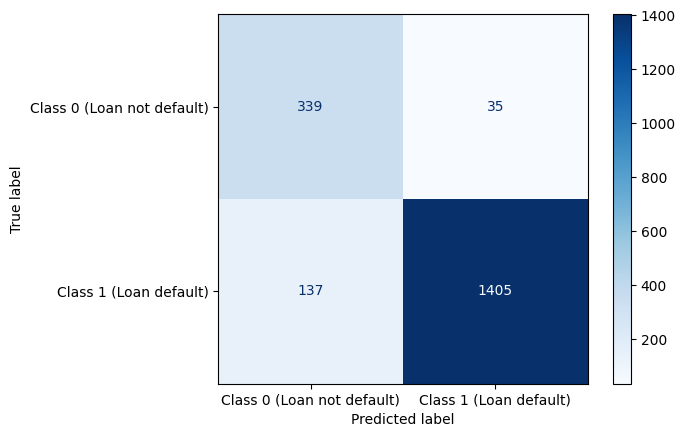

In [93]:
#  Evaluate Model
# Predict Probabilities
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_proba = model.predict(X_test_scaled).ravel()

# Predict Classes
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



cm = confusion_matrix(y_test, y_pred)

# Step 2: Define labels
labels = ['Class 0 (Loan not default)', 'Class 1 (Loan default)']

# Step 3: Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

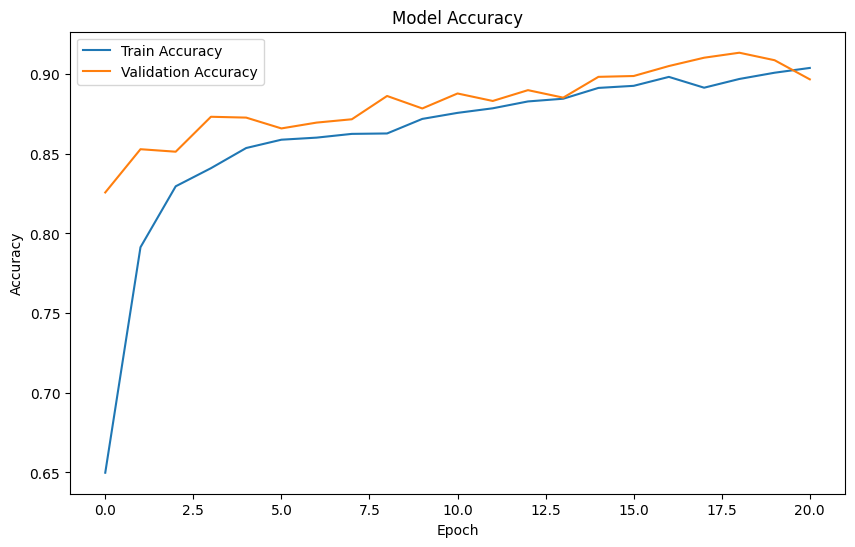

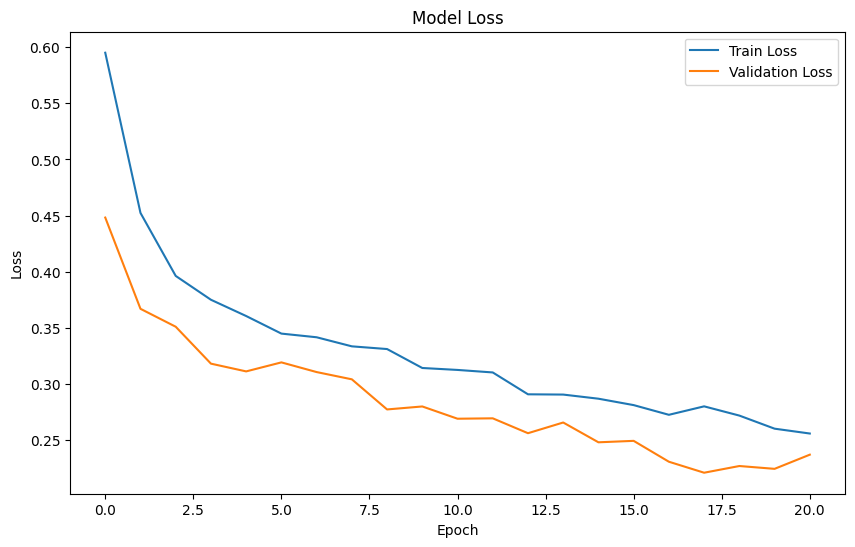

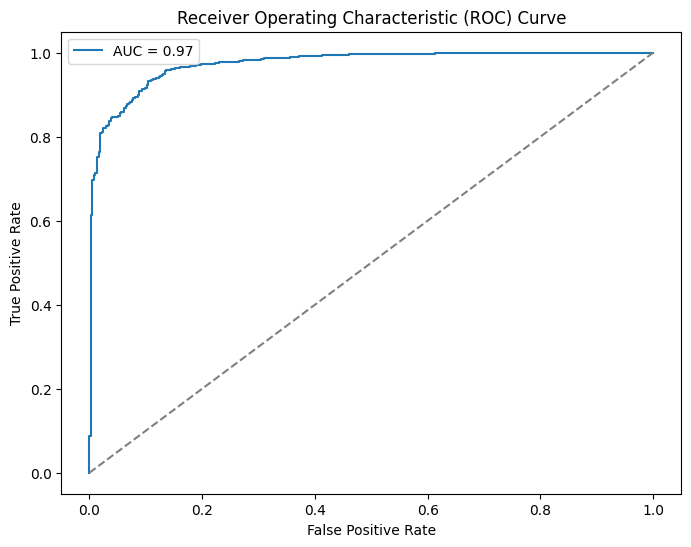

In [94]:
# 13. Plot Training History
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 14. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
